# 🎯 Step 4 : Topic Modeling (LDA)

**Objectif**: Identifier les thèmes latents dominants dans le corpus

**Méthode**: Latent Dirichlet Allocation (LDA)

**Analyses réalisées**:
1. Préparation des données pour LDA
2. Détermination du nombre optimal de topics (2-10)
3. Entraînement du modèle LDA
4. Extraction et interprétation des topics
5. Distribution des topics par document
6. Analyse comparative par type de source (Consulting vs Academic vs Industry)
7. Visualisations (pyLDAvis, bar charts, heatmaps)

**Output**: Topics identifiés + visualisations pour le rapport

## 🔧 Setup Config & Imports

In [9]:
import warnings
warnings.filterwarnings('ignore')

# Imports
import json
import pickle
from pathlib import Path
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# LDA & topic modeling
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Utilities
from tqdm.notebook import tqdm

# Viz Config
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

print("✅ Imports")

✅ Imports


c:\Users\hrobi\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\hrobi\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


## 📂 Load processed corpus

In [10]:
# Paths
PROJECT_ROOT = Path.cwd().parent
PROCESSED_DATA = PROJECT_ROOT / "data" / "processed"
CORPUS_FILE = PROCESSED_DATA / "preprocessed_corpus.pkl"
METADATA_FILE = PROCESSED_DATA / "metadata" / "corpus_metadata.json"

# Create folder for topic modeling results
TOPICS_DIR = PROCESSED_DATA / "topics"
TOPICS_DIR.mkdir(exist_ok=True)

print(f"📁 Topic modeling folder : {TOPICS_DIR}")

📁 Topic modeling folder : c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics


In [11]:
# Load processed corpus
with open(CORPUS_FILE, 'rb') as f:
    processed_corpus = pickle.load(f)

# Load metadata
with open(METADATA_FILE, 'r', encoding='utf-8') as f:
    metadata = json.load(f)

print(f"✅ {len(processed_corpus)} documents loaded")

✅ 20 documents loaded


In [12]:
# Mapping doc_id -> source_type
doc_to_source = {doc_id: metadata[doc_id]['source_type'] 
                 for doc_id in processed_corpus.keys()}

print(f"\n📊 Type distribution:")
for source_type, count in Counter(doc_to_source.values()).items():
    print(f"  • {source_type:15} : {count} document(s)")


📊 Type distribution:
  • Consulting      : 7 document(s)
  • Industry        : 5 document(s)
  • Academic        : 4 document(s)
  • Policy          : 4 document(s)


## 🔄 Data preparation for LDA

In [13]:
# Extract each doc tokens
documents_tokens = []
doc_ids_ordered = []

for doc_id, doc_data in processed_corpus.items():
    documents_tokens.append(doc_data['tokens'])
    doc_ids_ordered.append(doc_id)

print(f"\n✅ {len(documents_tokens)} documents prepared")


✅ 20 documents prepared


In [14]:
# Create dictionary (vocabulary)
dictionary = corpora.Dictionary(documents_tokens)

print(f"\n📚 Gensim dictionary created:")
print(f"   Initial vocabulary size : {len(dictionary)} words")


📚 Gensim dictionary created:
   Initial vocabulary size : 10097 words


In [15]:
# Filter extremums
# no_below: min docs where the word must exist
# no_above: max proportion of documents (avoid overly common words)
dictionary.filter_extremes(no_below=2, no_above=0.7)
print(f"   After filtering      : {len(dictionary)} words")

   After filtering      : 3168 words


In [16]:
# Create corpus (bag-of-words)
corpus_bow = [dictionary.doc2bow(doc) for doc in documents_tokens]

print(f"\n✅ Bag-of-Words corpus created ({len(corpus_bow)} documents)")


✅ Bag-of-Words corpus created (20 documents)


In [17]:
# Sample
print(f"\n📄 Example (1rst document):")
print(f"   Number of unique tokens: {len(corpus_bow[0])}")
print(f"   First 5 terms:")
for word_id, count in corpus_bow[0][:5]:
    print(f"      {dictionary[word_id]:20} : {count} occurrences")


📄 Example (1rst document):
   Number of unique tokens: 1742
   First 5 terms:
      aaron                : 2 occurrences
      able                 : 4 occurrences
      academic             : 2 occurrences
      accelerate           : 16 occurrences
      accelerates          : 1 occurrences


## 🔍 Topics optimal number determination

### Using coherence score

In [19]:
# Try different topic numbers
topic_range = range(2, 11)  # 2~10 topics
coherence_scores = []

print("\n🔄 Computing coherence scores (2~5 min)...\n")

for num_topics in tqdm(topic_range, desc="Testing topic counts"):
    # Train LDA model
    lda_model = LdaModel(
        corpus=corpus_bow,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=10,
        iterations=100,
        alpha='auto',
        per_word_topics=True
    )
    
    # Coherence score
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=documents_tokens,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    
    print(f"  {num_topics} topics: coherence = {coherence_score:.4f}")

print("\n✅ Computation of coherence scores completed")


🔄 Computing coherence scores (2~5 min)...



Testing topic counts:   0%|          | 0/9 [00:00<?, ?it/s]

  2 topics: coherence = 0.4022
  3 topics: coherence = 0.3823
  4 topics: coherence = 0.3966
  5 topics: coherence = 0.3401
  6 topics: coherence = 0.3968
  7 topics: coherence = 0.4200
  8 topics: coherence = 0.4192
  9 topics: coherence = 0.4010
  10 topics: coherence = 0.4114

✅ Computation of coherence scores completed


In [20]:
# Find optimal number
optimal_num_topics = list(topic_range)[np.argmax(coherence_scores)]

print(f"\n🎯 Optimal number of topics (max coherence): {optimal_num_topics}")


🎯 Optimal number of topics (max coherence): 7


c:\Users\hrobi\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\hrobi\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


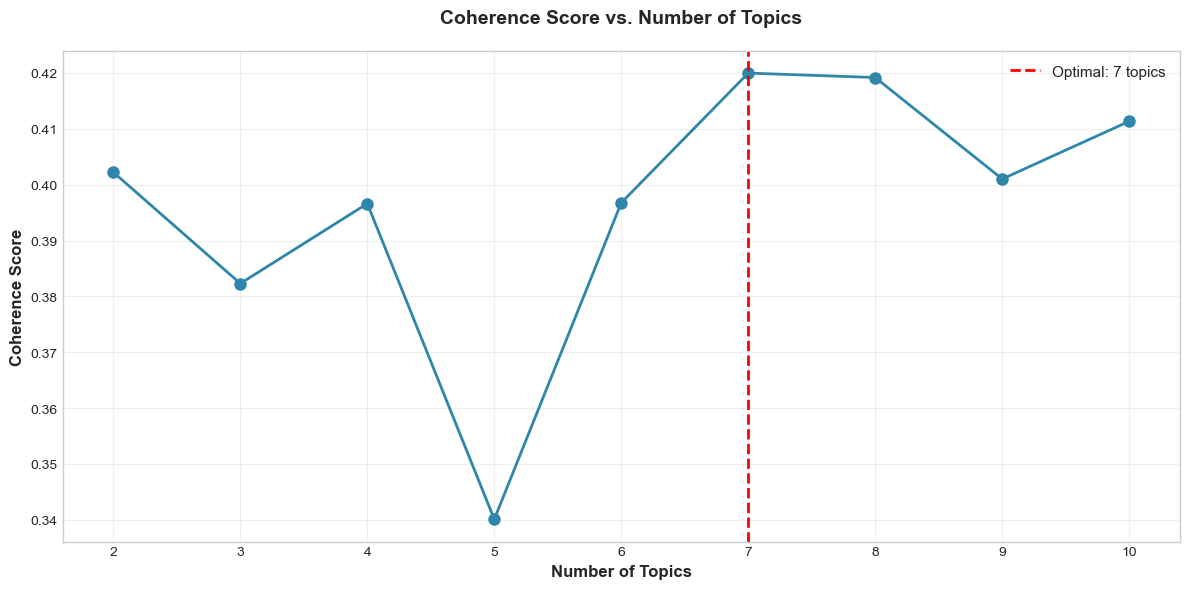


💾 Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\coherence_scores.png


In [21]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(topic_range, coherence_scores, marker='o', linewidth=2, markersize=8, color='#2E86AB')
ax.axvline(x=optimal_num_topics, color='red', linestyle='--', linewidth=2, 
           label=f'Optimal: {optimal_num_topics} topics')

ax.set_xlabel('Number of Topics', fontsize=12, fontweight='bold')
ax.set_ylabel('Coherence Score', fontsize=12, fontweight='bold')
ax.set_title('Coherence Score vs. Number of Topics', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(topic_range)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig(TOPICS_DIR / 'coherence_scores.png', bbox_inches='tight')
plt.show()

print(f"\n💾 Graph saved to: {TOPICS_DIR / 'coherence_scores.png'}")

### Using manual determination (if necessary)

In [22]:
# Possibilité d'override manuel basé sur l'interprétabilité
# Par défaut, on utilise le nombre optimal trouvé
# Mais tu peux choisir manuellement si les topics ne sont pas interprétables

MANUAL_OVERRIDE = None  # Put a number (ex: 5, 6, 7) to force

if MANUAL_OVERRIDE:
    final_num_topics = MANUAL_OVERRIDE
    print(f"\n⚠️ Manual override: use of {final_num_topics} topics")
else:
    final_num_topics = optimal_num_topics
    print(f"\n✅ Use of optimal number: {final_num_topics} topics")


✅ Use of optimal number: 7 topics


## 🚀 LDA model training

In [23]:
lda_model_final = LdaModel(
    corpus=corpus_bow,
    id2word=dictionary,
    num_topics=final_num_topics,
    random_state=42,
    passes=20,           # More passes for better training
    iterations=200,      # More iterations
    alpha='auto',        # Alpha auto
    eta='auto',          # Eta auto
    per_word_topics=True
)

print("\n✅ LDA model trained")


✅ LDA model trained


In [24]:
# Compute perplexity (lower = better)
perplexity = lda_model_final.log_perplexity(corpus_bow)
print(f"   Perplexity: {perplexity:.4f}")

   Perplexity: -7.4751


In [25]:
# Compute final coherence score
coherence_model_final = CoherenceModel(
    model=lda_model_final,
    texts=documents_tokens,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_final = coherence_model_final.get_coherence()
print(f"   Coherence:  {coherence_final:.4f}")

   Coherence:  0.3691


In [26]:
# Save model
lda_model_final.save(str(TOPICS_DIR / 'lda_model.model'))
dictionary.save(str(TOPICS_DIR / 'dictionary.dict'))
print(f"\n💾 Model saved to: {TOPICS_DIR / 'lda_model.model'}")


💾 Model saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\lda_model.model


## 🏷️ Topics extraction and interpretation

In [27]:
# Extract topics
topics_data = []

for topic_id in range(final_num_topics):
    # Top 15 topic words
    topic_words = lda_model_final.show_topic(topic_id, topn=15)
    
    print(f"TOPIC {topic_id}")
    
    words_str = []
    for word, prob in topic_words:
        print(f"  {word:20} : {prob:.4f}")
        words_str.append(f"{word} ({prob:.3f})")
    
    topics_data.append({
        'topic_id': topic_id,
        'top_words': ', '.join([w for w, p in topic_words[:10]]),
        'words_detailed': words_str
    })

TOPIC 0
  evaluation           : 0.0165
  foundation           : 0.0098
  organization         : 0.0075
  survey               : 0.0075
  assessment           : 0.0075
  autonomy             : 0.0072
  world                : 0.0058
  authority            : 0.0056
  security             : 0.0055
  operational          : 0.0051
  say                  : 0.0051
  classification       : 0.0050
  chief                : 0.0047
  officer              : 0.0042
  practice             : 0.0041
TOPIC 1
  organization         : 0.0121
  workflow             : 0.0085
  financial            : 0.0062
  partner              : 0.0056
  pool                 : 0.0052
  sale                 : 0.0047
  market               : 0.0045
  demand               : 0.0042
  leader               : 0.0041
  employee             : 0.0041
  enhance              : 0.0040
  shape                : 0.0040
  software             : 0.0039
  experience           : 0.0038
  investment           : 0.0037
TOPIC 2
  oecd          

## 🏷️ Topics manual labellisation

In [28]:
# Basé sur les mots clés, assigner des labels interprétables
# TU DEVRAS ADAPTER CETTE SECTION EN FONCTION DES TOPICS OBTENUS

# Exemple de mapping (à adapter selon tes résultats)
TOPIC_LABELS = {
    0: "Productivity & ROI",
    1: "Workforce Transformation",
    2: "Governance & Compliance",
    3: "Technical Architecture & Infrastructure",
    4: "Autonomous Work Orchestration",
    5: "AI Models & Algorithms",
    6: "Business Strategy & Implementation",
    7: "Human-AI Collaboration"
}

In [29]:
# Use only existing labels
topic_labels_final = {k: v for k, v in TOPIC_LABELS.items() if k < final_num_topics}

# If missing labels, create automatically
for topic_id in range(final_num_topics):
    if topic_id not in topic_labels_final:
        top_words = [w for w, p in lda_model_final.show_topic(topic_id, topn=3)]
        topic_labels_final[topic_id] = f"Topic {topic_id}: {', '.join(top_words)}"

print("\n📋 Assigned labels:")
for topic_id, label in topic_labels_final.items():
    print(f"  Topic {topic_id}: {label}")


📋 Assigned labels:
  Topic 0: Productivity & ROI
  Topic 1: Workforce Transformation
  Topic 2: Governance & Compliance
  Topic 3: Technical Architecture & Infrastructure
  Topic 4: Autonomous Work Orchestration
  Topic 5: AI Models & Algorithms
  Topic 6: Business Strategy & Implementation


In [30]:
print("\n⚠️ NOTE: Vérifiez et ajustez manuellement les labels dans la cellule précédente")
print("         en fonction des mots clés observés pour chaque topic.")


⚠️ NOTE: Vérifiez et ajustez manuellement les labels dans la cellule précédente
         en fonction des mots clés observés pour chaque topic.


In [31]:
# Add labels to DataFrame
for item in topics_data:
    item['label'] = topic_labels_final[item['topic_id']]

df_topics = pd.DataFrame(topics_data)

## 📊 Topics visualization (Key words)

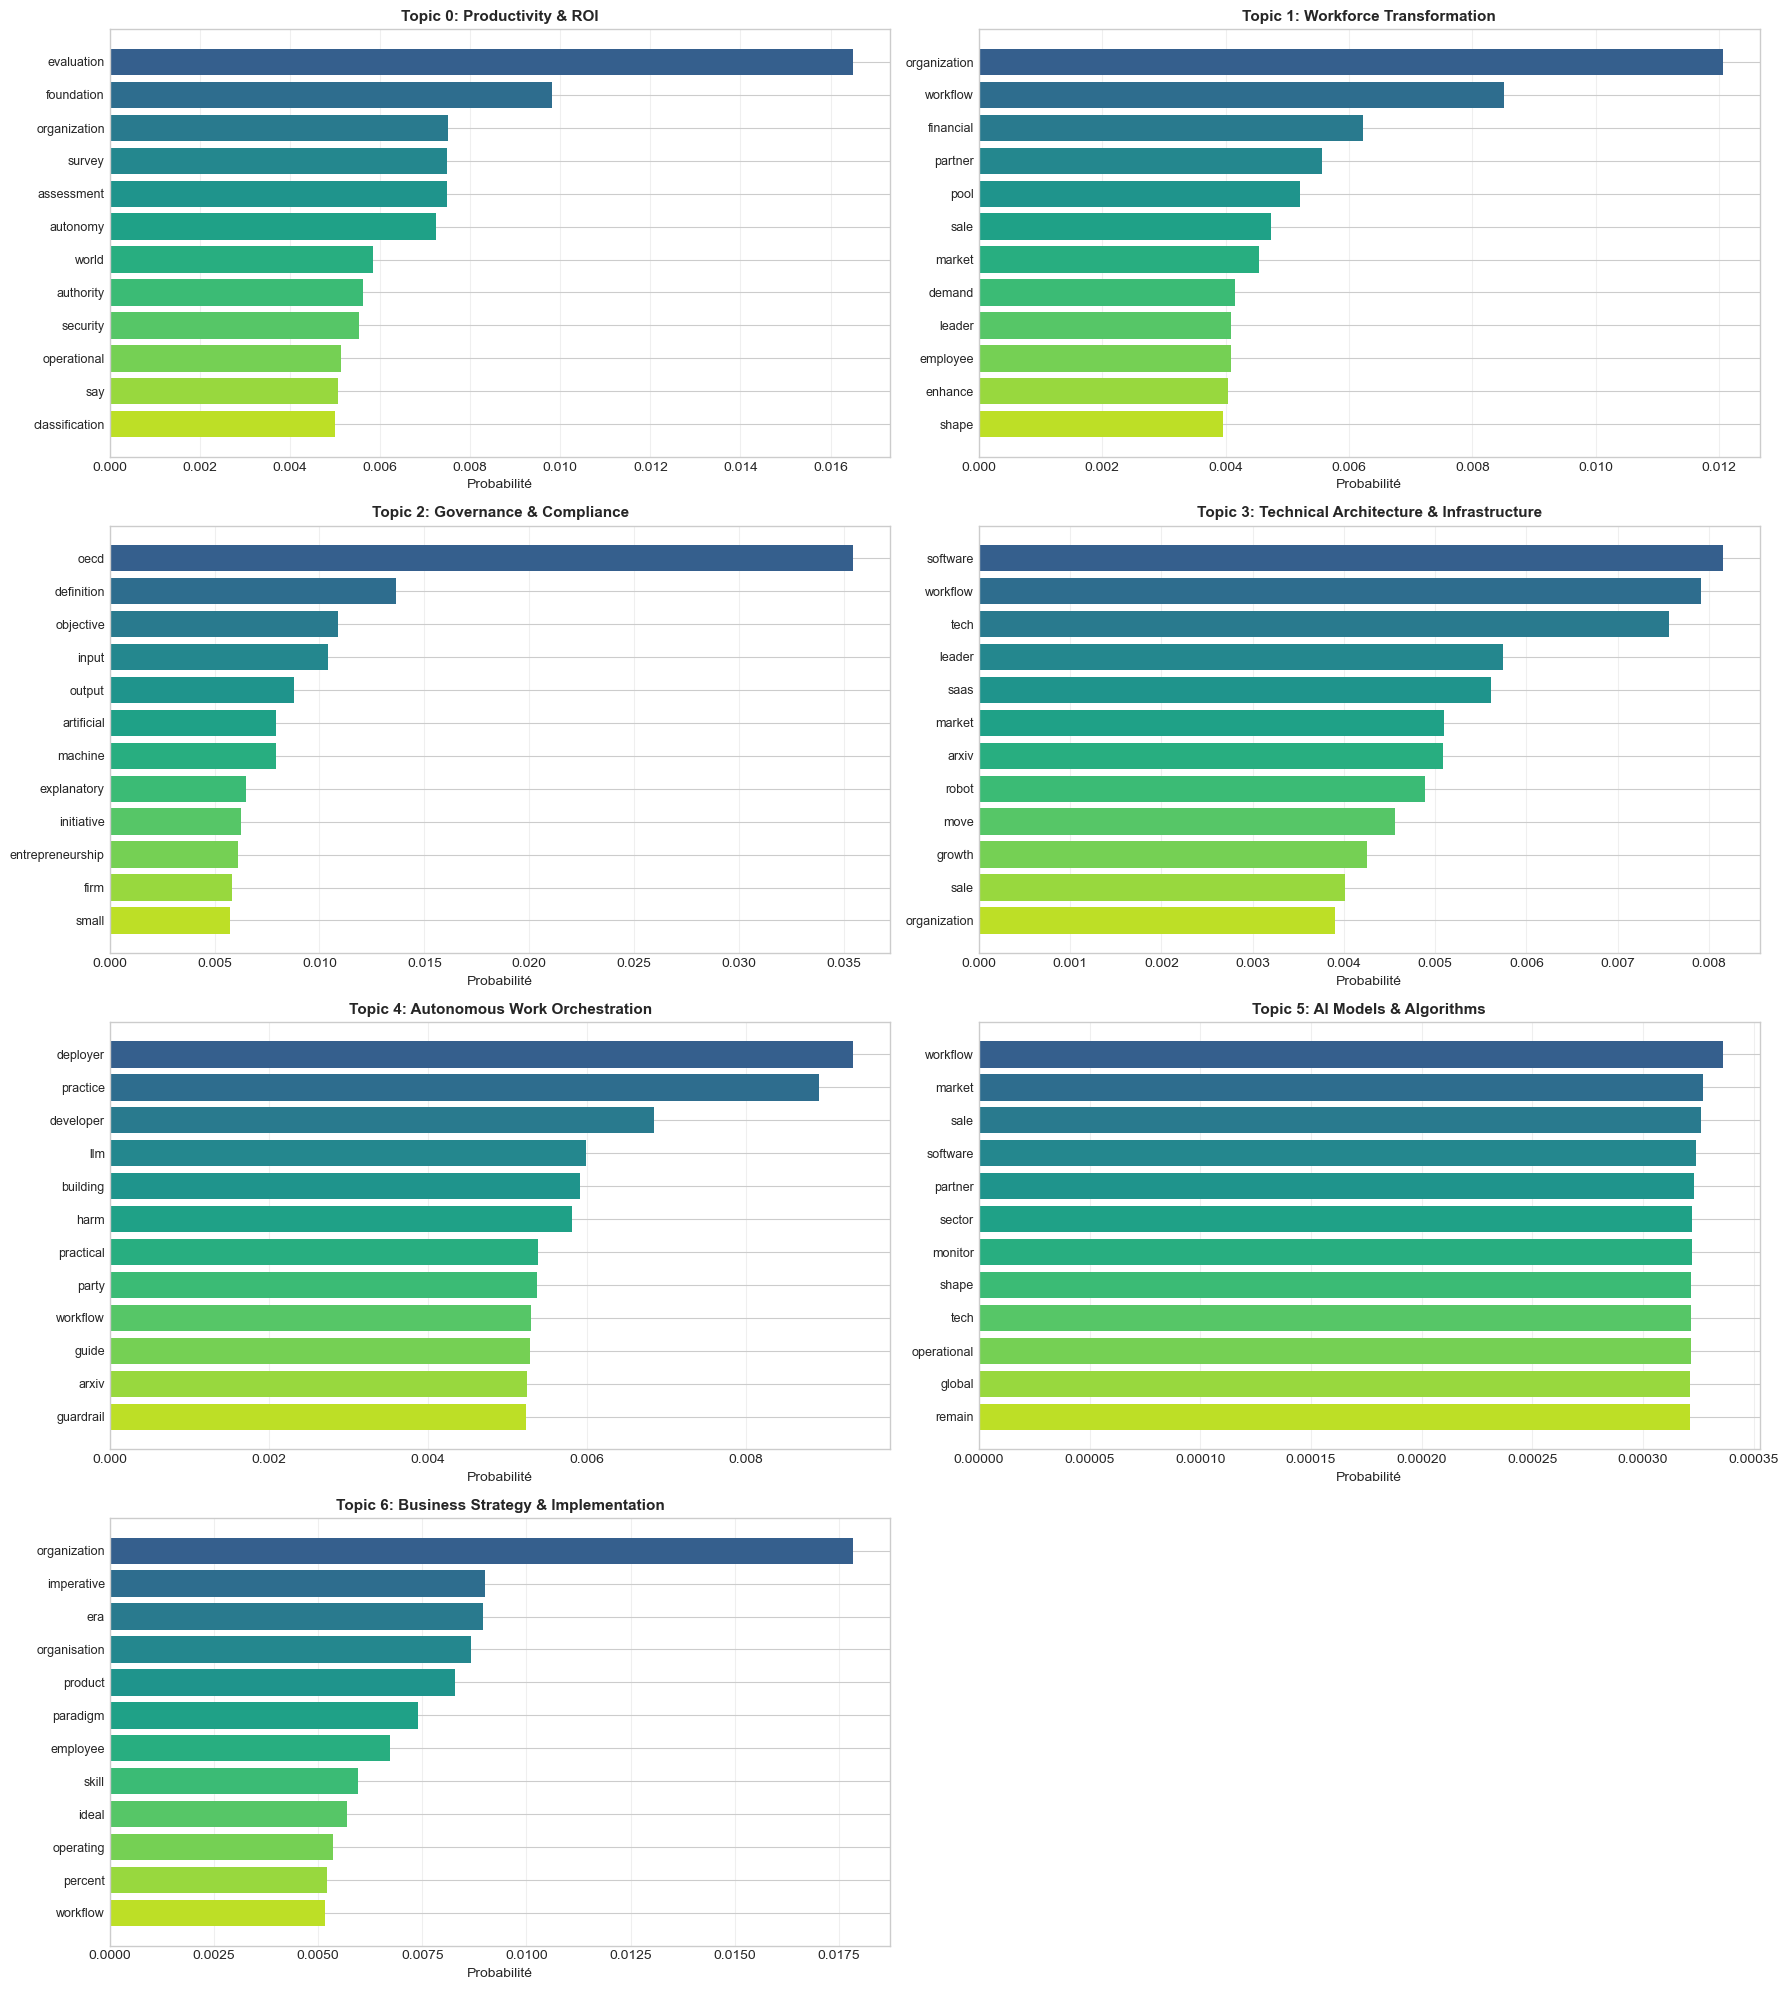

💾 Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\topics_keywords.png


In [32]:
n_topics = final_num_topics
n_cols = 2
n_rows = (n_topics + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten() if n_topics > 1 else [axes]

for topic_id in range(n_topics):
    ax = axes[topic_id]
    
    # Words + proba
    topic_words = lda_model_final.show_topic(topic_id, topn=12)
    words = [w for w, p in topic_words]
    probs = [p for w, p in topic_words]
    
    # Plotting
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(words)))
    ax.barh(range(len(words)), probs, color=colors)
    ax.set_yticks(range(len(words)))
    ax.set_yticklabels(words, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('Probabilité', fontsize=10)
    ax.set_title(f'Topic {topic_id}: {topic_labels_final[topic_id]}', 
                fontsize=11, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

# Remove empty axes if odd number of topics
if n_topics % 2 == 1:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig(TOPICS_DIR / 'topics_keywords.png', bbox_inches='tight')
plt.show()

print(f"💾 Graph saved to: {TOPICS_DIR / 'topics_keywords.png'}")

## 📈 Topics per document distribution

In [33]:
# Topics distribution for each document
doc_topics_data = []

for doc_idx, doc_id in enumerate(doc_ids_ordered):
    # Topic distribution for doc
    topic_dist = lda_model_final.get_document_topics(corpus_bow[doc_idx])
    
    # Convert to dictionary (including prob=0 topics)
    topic_dict = {i: 0.0 for i in range(final_num_topics)}
    for topic_id, prob in topic_dist:
        topic_dict[topic_id] = prob
    
    # Find dominant topic
    dominant_topic = max(topic_dict.items(), key=lambda x: x[1])[0]
    
    doc_topics_data.append({
        'doc_id': doc_id,
        'filename': metadata[doc_id]['filename'],
        'source_type': doc_to_source[doc_id],
        'dominant_topic': dominant_topic,
        'dominant_topic_label': topic_labels_final[dominant_topic],
        **{f'topic_{i}': prob for i, prob in topic_dict.items()}
    })

df_doc_topics = pd.DataFrame(doc_topics_data)
df_doc_topics.head() # Check

,doc_id,filename,source_type,dominant_topic,dominant_topic_label,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,Bain_report_technology_report_2025,Bain_report_technology_report_2025.pdf,Consulting,3,Technical Architecture & Infrastructure,0.0,0.000000,0.00000,0.999977,0.000000,0.0,0.000000
1,BCG_AI_Agents_2025,BCG_AI_Agents_2025.pdf,Consulting,1,Workforce Transformation,0.0,0.398113,0.02596,0.358369,0.217422,0.0,0.000000
2,Deloitte_The_business_imperative_for_Agentic_A...,Deloitte_The_business_imperative_for_Agentic_A...,Consulting,6,Business Strategy & Implementation,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.999843
3,Google_Agentic_AI_TAM_Analysis_2025,Google_Agentic_AI_TAM_Analysis_2025.pdf,Industry,1,Workforce Transformation,0.0,0.999983,0.00000,0.000000,0.000000,0.0,0.000000
4,Google_The_ROI_of_AI_2025,Google_The_ROI_of_AI_2025.pdf,Industry,1,Workforce Transformation,0.0,0.587170,0.00000,0.412502,0.000000,0.0,0.000000


In [34]:
print("\n📋 Distribution per document (first documents):\n")
display_cols = ['filename', 'source_type', 'dominant_topic_label'] + \
               [f'topic_{i}' for i in range(final_num_topics)]

df_doc_topics[display_cols].head(10)


📋 Distribution per document (first documents):



,filename,source_type,dominant_topic_label,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,Bain_report_technology_report_2025.pdf,Consulting,Technical Architecture & Infrastructure,0.0,0.000000,0.00000,0.999977,0.000000,0.0,0.000000
1,BCG_AI_Agents_2025.pdf,Consulting,Workforce Transformation,0.0,0.398113,0.02596,0.358369,0.217422,0.0,0.000000
2,Deloitte_The_business_imperative_for_Agentic_A...,Consulting,Business Strategy & Implementation,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.999843
3,Google_Agentic_AI_TAM_Analysis_2025.pdf,Industry,Workforce Transformation,0.0,0.999983,0.00000,0.000000,0.000000,0.0,0.000000
4,Google_The_ROI_of_AI_2025.pdf,Industry,Workforce Transformation,0.0,0.587170,0.00000,0.412502,0.000000,0.0,0.000000
5,Harvard_Designing_a_Successful_Agentic_AI_Syst...,Academic,Workforce Transformation,0.0,0.909885,0.00000,0.000000,0.089970,0.0,0.000000
6,ITI_Understanding_Agentic_AI_Policy_Guide_2025...,Policy,Autonomous Work Orchestration,0.0,0.101184,0.00000,0.000000,0.898750,0.0,0.000000
7,McKinsey_Empowering_advanced_industries_with_a...,Consulting,Workforce Transformation,0.0,0.564785,0.00000,0.298041,0.000000,0.0,0.137075
8,McKinsey_The_agentic_organization_contours_of_...,Consulting,Business Strategy & Implementation,0.0,0.000000,0.00000,0.227806,0.000000,0.0,0.772113
9,McKinsey_What_is_an_AI_Agent_2025.pdf,Consulting,Technical Architecture & Infrastructure,0.0,0.093143,0.00000,0.772588,0.100729,0.0,0.033487


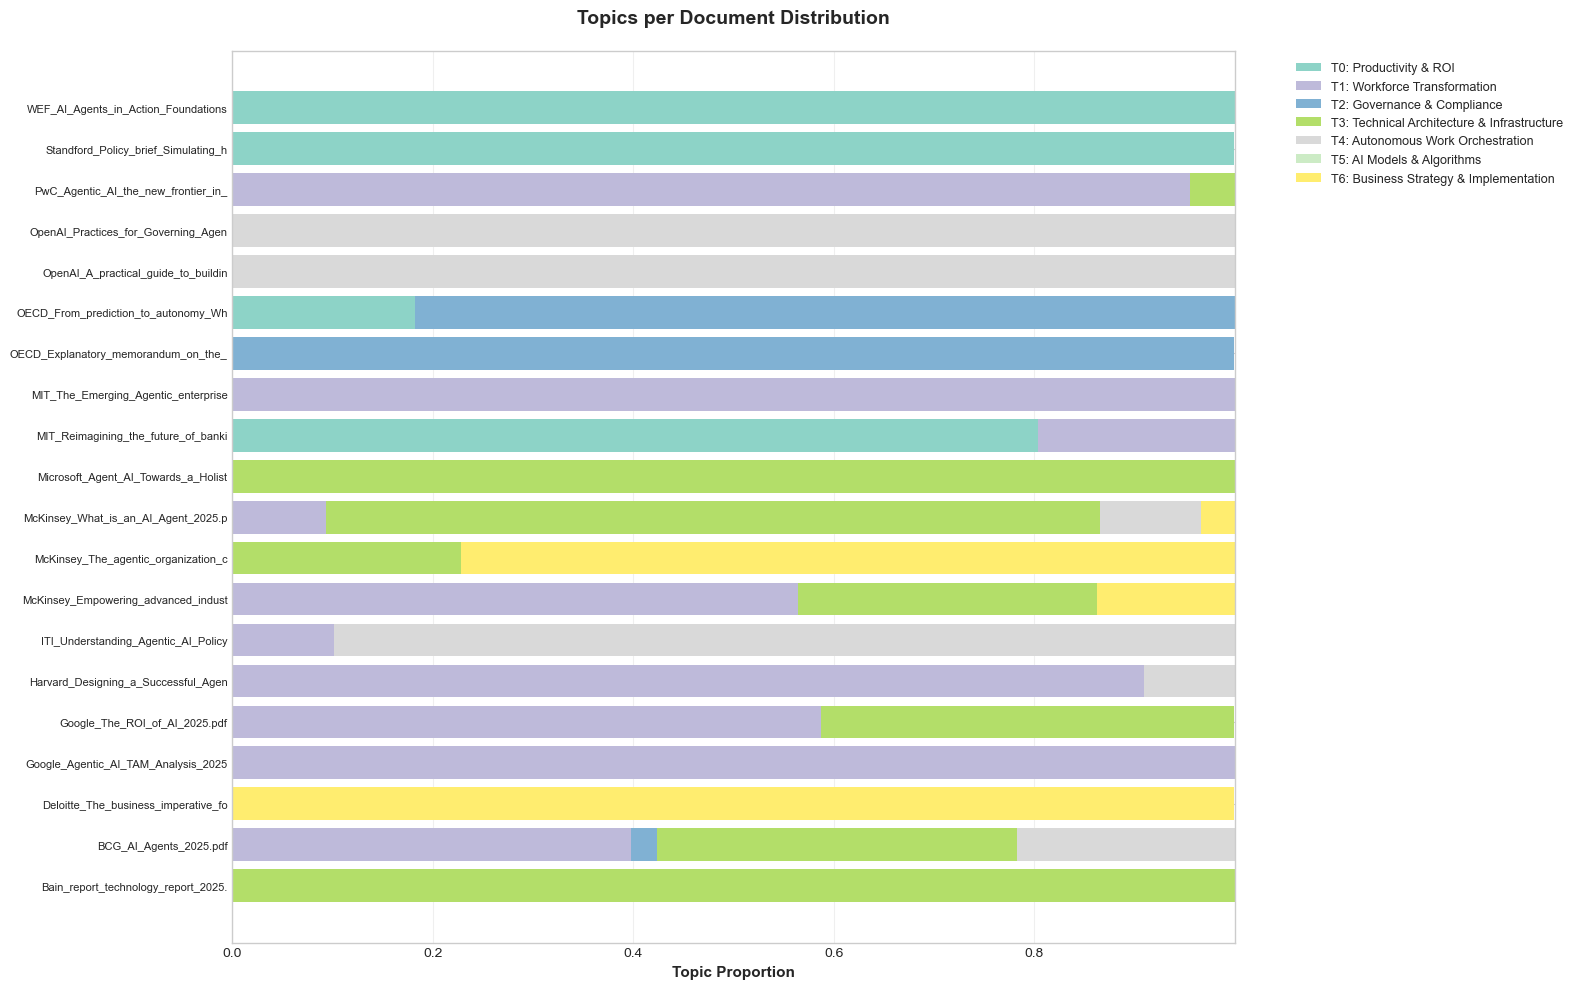

💾 Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\topic_distribution_by_document.png


In [35]:
topic_columns = [f'topic_{i}' for i in range(final_num_topics)]
topic_data = df_doc_topics[topic_columns].values

fig, ax = plt.subplots(figsize=(16, 10))

# Create stacked bars
bottom = np.zeros(len(df_doc_topics))
colors = plt.cm.Set3(np.linspace(0, 1, final_num_topics))

for topic_id in range(final_num_topics):
    values = df_doc_topics[f'topic_{topic_id}'].values
    ax.barh(range(len(df_doc_topics)), values, left=bottom, 
           label=f'T{topic_id}: {topic_labels_final[topic_id]}',
           color=colors[topic_id])
    bottom += values

ax.set_yticks(range(len(df_doc_topics)))
ax.set_yticklabels(df_doc_topics['filename'].str[:35], fontsize=8)
ax.set_xlabel('Topic Proportion', fontsize=11, fontweight='bold')
ax.set_title('Topics per Document Distribution', fontsize=14, fontweight='bold', pad=20)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(TOPICS_DIR / 'topic_distribution_by_document.png', bbox_inches='tight')
plt.show()

print(f"💾 Graph saved to: {TOPICS_DIR / 'topic_distribution_by_document.png'}")

## 📊 Topics global distribution 

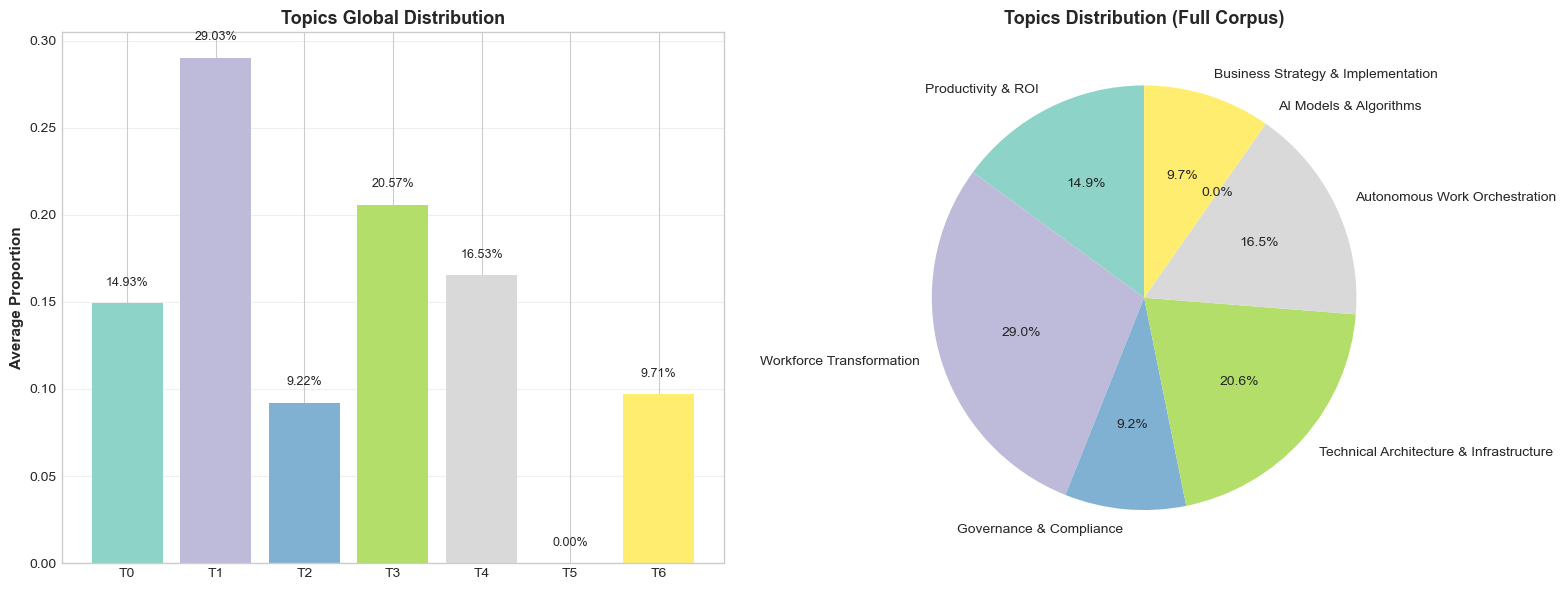

💾 Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\topic_global_distribution.png


In [37]:
# Compute average proportion of each topic in corpus
topic_proportions = df_doc_topics[topic_columns].mean().values

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
axes[0].bar(range(final_num_topics), topic_proportions, 
           color=colors, linewidth=1.5)
axes[0].set_xticks(range(final_num_topics))
axes[0].set_xticklabels([f'T{i}' for i in range(final_num_topics)])
axes[0].set_ylabel('Average Proportion', fontsize=11, fontweight='bold')
axes[0].set_title('Topics Global Distribution', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for i, prop in enumerate(topic_proportions):
    axes[0].text(i, prop + 0.01, f'{prop:.2%}', ha='center', fontsize=9)

# Pie chart
axes[1].pie(topic_proportions, 
           labels=[topic_labels_final[i] for i in range(final_num_topics)],
           autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Topics Distribution (Full Corpus)', 
                 fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(TOPICS_DIR / 'topic_global_distribution.png', bbox_inches='tight')
plt.show()

print(f"💾 Graph saved to: {TOPICS_DIR / 'topic_global_distribution.png'}")

In [38]:
print("\n📊 Global topic proportions:")
for i, prop in enumerate(topic_proportions):
    print(f"  {topic_labels_final[i]:40} : {prop:.1%}")


📊 Global topic proportions:
  Productivity & ROI                       : 14.9%
  Workforce Transformation                 : 29.0%
  Governance & Compliance                  : 9.2%
  Technical Architecture & Infrastructure  : 20.6%
  Autonomous Work Orchestration            : 16.5%
  AI Models & Algorithms                   : 0.0%
  Business Strategy & Implementation       : 9.7%


## 🔍 Comparative analysis per source type

In [39]:
# Compute average proportions per type
topic_by_source = df_doc_topics.groupby('source_type')[topic_columns].mean()

print("\n📋 Average topics proportions per source type:\n")
topic_by_source.round(3)


📋 Average topics proportions per source type:



,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
source_type,,,,,,,
Academic,0.451,0.526,0.000,0.000,0.022,0.0,0.000
Consulting,0.000,0.287,0.004,0.386,0.045,0.0,0.278
Industry,0.000,0.317,0.000,0.282,0.400,0.0,0.000
Policy,0.295,0.025,0.454,0.000,0.225,0.0,0.000


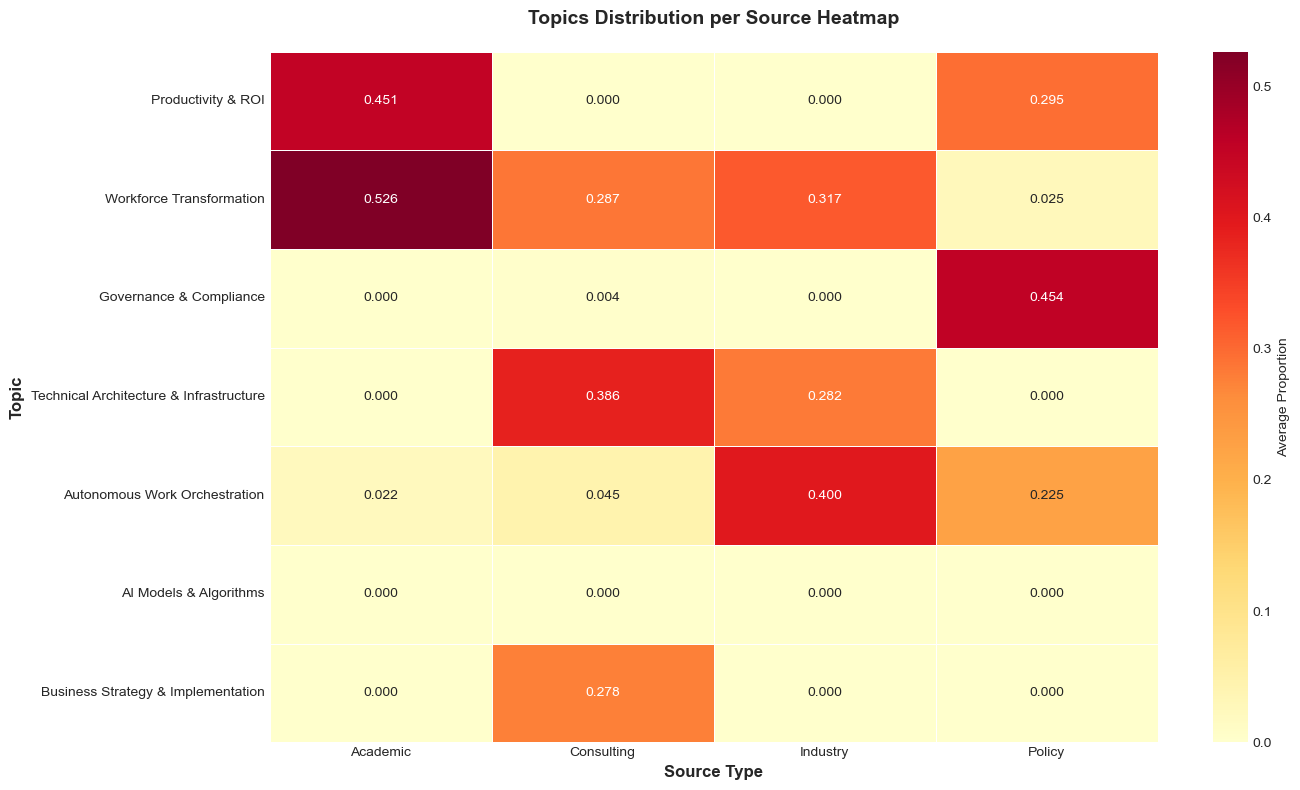

💾 Heatmap saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\heatmap_topics_by_source.png


In [40]:
# Heatmap visualization
fig, ax = plt.subplots(figsize=(14, 8))

# Rename columns
topic_by_source_labeled = topic_by_source.copy()
topic_by_source_labeled.columns = [topic_labels_final[i] for i in range(final_num_topics)]

sns.heatmap(topic_by_source_labeled.T, annot=True, fmt='.3f', cmap='YlOrRd',
           linewidths=0.5, cbar_kws={'label': 'Average Proportion'}, ax=ax)

ax.set_xlabel('Source Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Topic', fontsize=12, fontweight='bold')
ax.set_title('Topics Distribution per Source Heatmap', 
            fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(TOPICS_DIR / 'heatmap_topics_by_source.png', bbox_inches='tight')
plt.show()

print(f"💾 Heatmap saved to: {TOPICS_DIR / 'heatmap_topics_by_source.png'}")

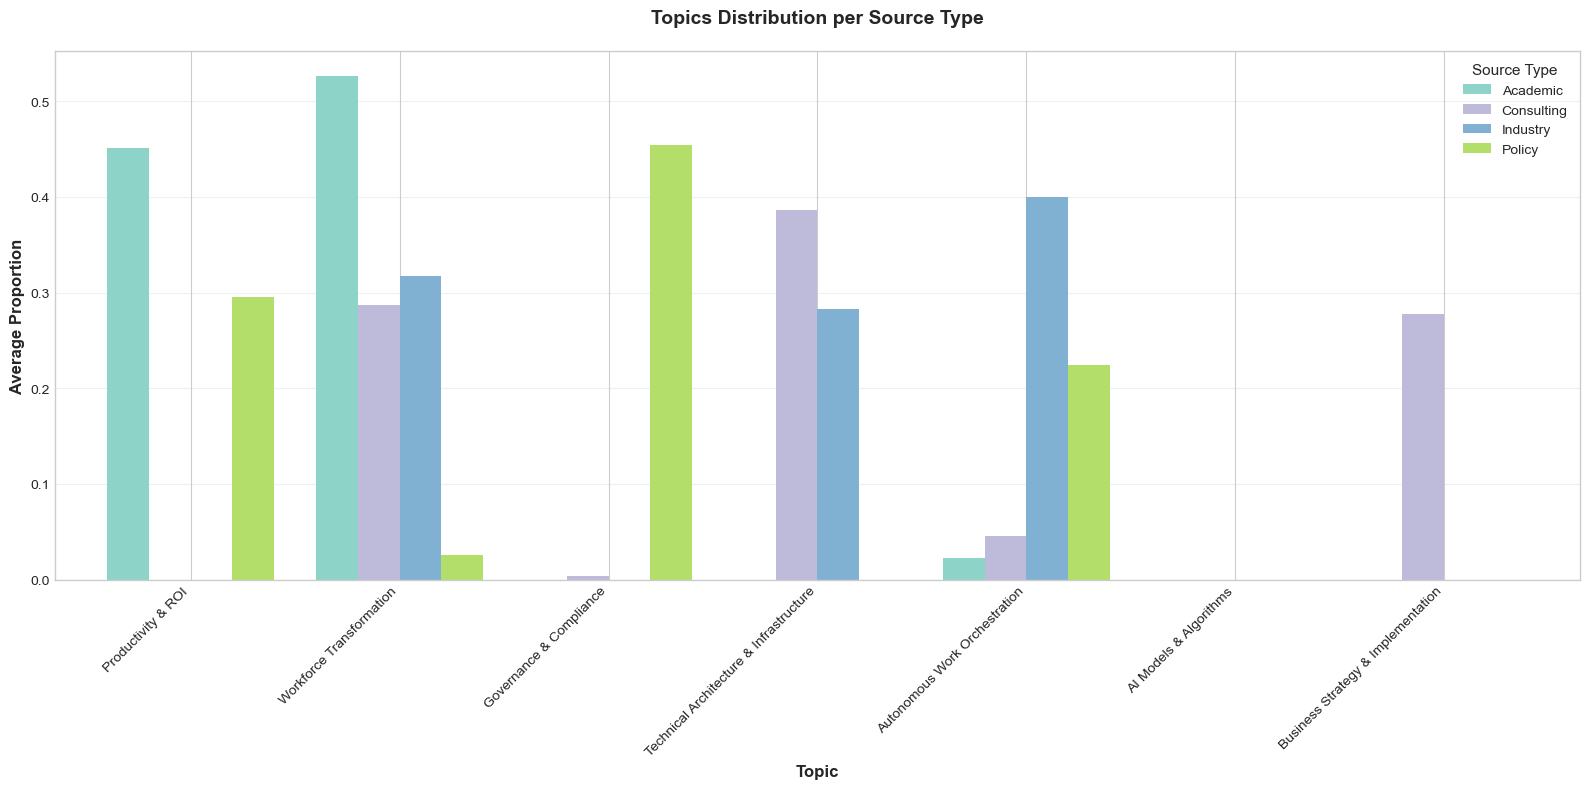

💾 Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\topics_by_source_grouped.png


In [41]:
# Bar chart grouped
fig, ax = plt.subplots(figsize=(16, 8))

topic_by_source_labeled.T.plot(kind='bar', ax=ax, width=0.8, color=colors[:len(topic_by_source)])

ax.set_ylabel('Average Proportion', fontsize=12, fontweight='bold')
ax.set_xlabel('Topic', fontsize=12, fontweight='bold')
ax.set_title('Topics Distribution per Source Type', 
            fontsize=14, fontweight='bold', pad=20)
ax.legend(title='Source Type', fontsize=10, title_fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(TOPICS_DIR / 'topics_by_source_grouped.png', bbox_inches='tight')
plt.show()

print(f"💾 Graph saved to: {TOPICS_DIR / 'topics_by_source_grouped.png'}")

## 🎯 Dominant topic per source type

In [42]:
for source_type in topic_by_source.index:
    dominant_topic_id = topic_by_source.loc[source_type].idxmax()
    dominant_topic_id = int(dominant_topic_id.split('_')[1])
    proportion = topic_by_source.loc[source_type, f'topic_{dominant_topic_id}']
    
    print(f"\n{source_type}:")
    print(f"  Dominant topic : {topic_labels_final[dominant_topic_id]}")
    print(f"  Proportion     : {proportion:.1%}")


Academic:
  Dominant topic : Workforce Transformation
  Proportion     : 52.6%

Consulting:
  Dominant topic : Technical Architecture & Infrastructure
  Proportion     : 38.6%

Industry:
  Dominant topic : Autonomous Work Orchestration
  Proportion     : 40.0%

Policy:
  Dominant topic : Governance & Compliance
  Proportion     : 45.4%


## 📊 Interactive visualization using `pyLDAvis`

In [43]:
vis_data = gensimvis.prepare(lda_model_final, corpus_bow, dictionary, sort_topics=False)

# Save HTML
html_path = TOPICS_DIR / 'lda_visualization.html'
pyLDAvis.save_html(vis_data, str(html_path))

print(f"\n✅ Interactive visualization generated: {html_path}")
print(f"   Open file in browser to explore topics")

# Display in notebook (optional => too slow, would not recommend)
# pyLDAvis.display(vis_data)


✅ Interactive visualization generated: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\lda_visualization.html
   Open file in browser to explore topics


## 💾 Save results

In [44]:
# Save topics with associated key words
df_topics.to_csv(TOPICS_DIR / 'topics_keywords.csv', index=False)
print(f"✅ Topics and key words saved to: {TOPICS_DIR / 'topics_keywords.csv'}")

✅ Topics and key words saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\topics_keywords.csv


In [45]:
# Save distribution per document
df_doc_topics.to_csv(TOPICS_DIR / 'document_topic_distribution.csv', index=False)
print(f"✅ Distribution per document saved to: {TOPICS_DIR / 'document_topic_distribution.csv'}")

✅ Distribution per document saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\document_topic_distribution.csv


In [46]:
# Save proportions per type
topic_by_source.to_csv(TOPICS_DIR / 'topics_by_source_type.csv')
print(f"✅ Topics per type saved to: {TOPICS_DIR / 'topics_by_source_type.csv'}")

✅ Topics per type saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\topics_by_source_type.csv


In [47]:
# Save results summary
summary = {
    'num_topics': final_num_topics,
    'coherence_score': float(coherence_final),
    'perplexity': float(perplexity),
    'topic_labels': topic_labels_final,
    'global_proportions': {topic_labels_final[i]: float(prop) 
                          for i, prop in enumerate(topic_proportions)}
}

with open(TOPICS_DIR / 'lda_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✅ Summary saved to: {TOPICS_DIR / 'lda_summary.json'}")

✅ Summary saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\lda_summary.json


In [48]:
# Create textual report
report = f"""
{'='*70}
TOPIC MODELING (LDA) REPORT
{'='*70}

MODEL PARAMETERS
{'─'*70}
Number of topics    : {final_num_topics}
Coherence score     : {coherence_final:.4f}
Perplexity          : {perplexity:.4f}
Number of documents : {len(doc_ids_ordered)}

IDENTIFIED TOPICS
{'─'*70}
"""

for topic_id in range(final_num_topics):
    top_words = ', '.join([w for w, p in lda_model_final.show_topic(topic_id, topn=10)])
    report += f"\nTopic {topic_id}: {topic_labels_final[topic_id]}\n"
    report += f"  Key words: {top_words}\n"
    report += f"  Global proportion: {topic_proportions[topic_id]:.1%}\n"

report += f"\n{'─'*70}\n"
report += "DISTRIBUTION PER SOURCE TYPE\n"
report += f"{'─'*70}\n"

for source_type in topic_by_source.index:
    report += f"\n{source_type}:\n"
    for topic_id in range(final_num_topics):
        prop = topic_by_source.loc[source_type, f'topic_{topic_id}']
        if prop > 0.05:  # Display only if > 5%
            report += f"  • {topic_labels_final[topic_id]:40} : {prop:.1%}\n"

report += f"\n{'='*70}\n"

# Save report
report_path = TOPICS_DIR / 'lda_report.txt'
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report)

print(f"✅ Textual report saved to: {report_path}")

✅ Textual report saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\lda_report.txt


In [49]:
print("\n" + report) # Check format



TOPIC MODELING (LDA) REPORT

MODEL PARAMETERS
──────────────────────────────────────────────────────────────────────
Number of topics    : 7
Coherence score     : 0.3691
Perplexity          : -7.4751
Number of documents : 20

IDENTIFIED TOPICS
──────────────────────────────────────────────────────────────────────

Topic 0: Productivity & ROI
  Key words: evaluation, foundation, organization, survey, assessment, autonomy, world, authority, security, operational
  Global proportion: 14.9%

Topic 1: Workforce Transformation
  Key words: organization, workflow, financial, partner, pool, sale, market, demand, leader, employee
  Global proportion: 29.0%

Topic 2: Governance & Compliance
  Key words: oecd, definition, objective, input, output, artificial, machine, explanatory, initiative, entrepreneurship
  Global proportion: 9.2%

Topic 3: Technical Architecture & Infrastructure
  Key words: software, workflow, tech, leader, saas, market, arxiv, robot, move, growth
  Global proportion: 20.

## 📊 Insights summary for report use

In [50]:
print("\n🔹 DOMINANTS TOPICS (Global):")
sorted_topics = sorted(enumerate(topic_proportions), key=lambda x: x[1], reverse=True)
for i, (topic_id, prop) in enumerate(sorted_topics[:3], 1):
    print(f"  {i}. {topic_labels_final[topic_id]:40} : {prop:.1%}")

print("\n🔹 DIFFERENCES PER SOURCE TYPE:")
for source_type in topic_by_source.index:
    top_2_topics = topic_by_source.loc[source_type].nlargest(2)
    print(f"\n  {source_type}:")
    for topic_col in top_2_topics.index:
        topic_id = int(topic_col.split('_')[1])
        prop = top_2_topics[topic_col]
        print(f"    • {topic_labels_final[topic_id]:35} : {prop:.1%}")

print("\n🔹 CONVERGENCE/DIVERGENCE:")
# Compute variance between types for each topic
topic_variances = []
for topic_id in range(final_num_topics):
    col = f'topic_{topic_id}'
    variance = topic_by_source[col].var()
    topic_variances.append((topic_id, variance))

# Topics with greatest variance = more divergence between types
sorted_by_variance = sorted(topic_variances, key=lambda x: x[1], reverse=True)

print("\n  Topics with STRONG divergence between types:")
for topic_id, var in sorted_by_variance[:3]:
    print(f"    • {topic_labels_final[topic_id]:35} (variance: {var:.4f})")

print("\n  Topics with WEAK divergence (consensus):")
for topic_id, var in sorted_by_variance[-3:]:
    print(f"    • {topic_labels_final[topic_id]:35} (variance: {var:.4f})")


🔹 DOMINANTS TOPICS (Global):
  1. Workforce Transformation                 : 29.0%
  2. Technical Architecture & Infrastructure  : 20.6%
  3. Autonomous Work Orchestration            : 16.5%

🔹 DIFFERENCES PER SOURCE TYPE:

  Academic:
    • Workforce Transformation            : 52.6%
    • Productivity & ROI                  : 45.1%

  Consulting:
    • Technical Architecture & Infrastructure : 38.6%
    • Workforce Transformation            : 28.7%

  Industry:
    • Autonomous Work Orchestration       : 40.0%
    • Workforce Transformation            : 31.7%

  Policy:
    • Governance & Compliance             : 45.4%
    • Productivity & ROI                  : 29.5%

🔹 CONVERGENCE/DIVERGENCE:

  Topics with STRONG divergence between types:
    • Governance & Compliance             (variance: 0.0514)
    • Productivity & ROI                  (variance: 0.0505)
    • Workforce Transformation            (variance: 0.0422)

  Topics with WEAK divergence (consensus):
    • Autonomous W

## 🎯 Documents hierarchical clustering

In [51]:
# Use topics distributions as features
topic_features = df_doc_topics[topic_columns].values

# Compute cosine matrix
distances = pdist(topic_features, metric='cosine')

# Hierarchical linkage
linkage_matrix = linkage(distances, method='ward')

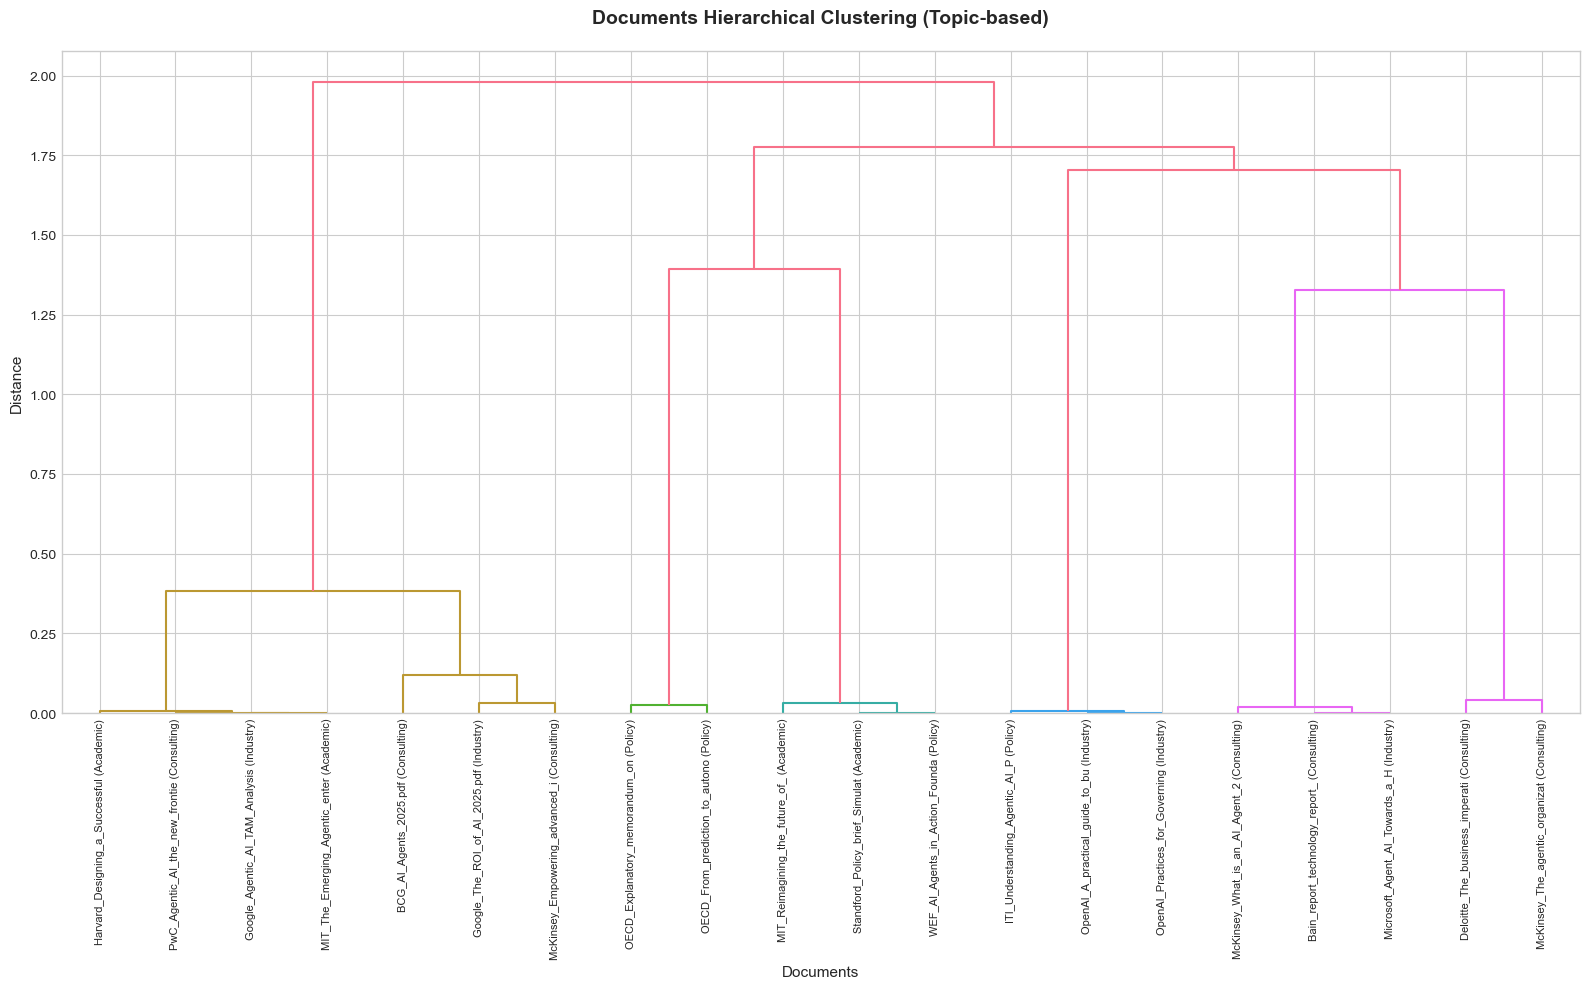

💾 Dendrogram saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics\hierarchical_clustering.png


In [52]:
# Plotting
fig, ax = plt.subplots(figsize=(16, 10))

# Create labels (name + type)
labels = [f"{metadata[doc_id]['filename'][:30]} ({doc_to_source[doc_id]})" 
          for doc_id in doc_ids_ordered]

dendrogram(
    linkage_matrix,
    labels=labels,
    leaf_rotation=90,
    leaf_font_size=8,
    ax=ax
)

ax.set_title('Documents Hierarchical Clustering (Topic-based)', 
            fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Documents', fontsize=11)
ax.set_ylabel('Distance', fontsize=11)

plt.tight_layout()
plt.savefig(TOPICS_DIR / 'hierarchical_clustering.png', bbox_inches='tight')
plt.show()

print(f"💾 Dendrogram saved to: {TOPICS_DIR / 'hierarchical_clustering.png'}")

In [53]:
print("\n📊 Interpretation:")
print("  • Near documents = similar topics distributions")
print("  • Clusters = groups of documents on similar themes")


📊 Interpretation:
  • Near documents = similar topics distributions
  • Clusters = groups of documents on similar themes


## 📋 Step 4 summary

**✅ Analyses complétées:**
- Détermination nombre optimal de topics (coherence score)
- Entraînement modèle LDA final
- Extraction et labellisation des topics
- Distribution des topics par document
- Analyse comparative par type de source
- Clustering hiérarchique des documents

**📂 Fichiers générés:**
- Modèle LDA et dictionnaire sauvegardés
- 8+ visualisations PNG
- 4 fichiers CSV avec données détaillées
- Visualisation interactive HTML (pyLDAvis)
- Rapport texte complet

**📊 Visuels pour le rapport:**
1. `coherence_scores.png` - Choix du nombre de topics
2. `topics_keywords.png` - Mots clés par topic
3. `topic_distribution_by_document.png` - Distribution par document
4. `topic_global_distribution.png` - Vue d'ensemble
5. `heatmap_topics_by_source.png` - Comparaison par type
6. `topics_by_source_grouped.png` - Barres groupées
7. `hierarchical_clustering.png` - Clustering documents
8. `lda_visualization.html` - Visualisation interactive

**➡️ Prochaine étape:**
- Étape 5: Mini-Taxonomy des définitions d'"Agentic AI"

In [54]:
# Summary Step 4
print("STEP 4 FINISHED SUCCESSFULLY!")
print(f"\n📊 Topic Modeling summary:")
print(f"  • Number of topics         : {final_num_topics:,}")
print(f"  • Coherence score          : {coherence_final:.4f}")
print(f"  • Identified topics        : {', '.join([f'T{i}' for i in range(final_num_topics)])}")
print(f"  • Analyzed documents       : {len(doc_ids_ordered)}")
print(f"  • Sources types            : {len(topic_by_source)}")
print(f"\n📂 All files saved to: {TOPICS_DIR}")
print(f"\n➡️ Ready for Step 5: Mini-Taxonomy of Definitions\n")

STEP 4 FINISHED SUCCESSFULLY!

📊 Topic Modeling summary:
  • Number of topics         : 7
  • Coherence score          : 0.3691
  • Identified topics        : T0, T1, T2, T3, T4, T5, T6
  • Analyzed documents       : 20
  • Sources types            : 4

📂 All files saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\topics

➡️ Ready for Step 5: Mini-Taxonomy of Definitions

